In [19]:
import pandas as pd

pd.set_option("display.max_columns", None)        # 컬럼 수 제한 제거
pd.set_option("display.width", 200)              # 한 줄 폭 넓게
pd.set_option("display.expand_frame_repr", False) # DataFrame 줄바꿈 금지


In [4]:
# ============================================
# 1. df 전처리
# ============================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1-1) CSV 로드 (경로는 환경에 맞게 수정)
csv_path = "/Users/gy/projects/trading-project/data_raw/usdjpym20_20251117_035207.csv"

df = pd.read_csv(csv_path, sep=";")

# 1-2) Date + Time → datetime index
df["ts"] = pd.to_datetime(df["Date"] + " " + df["Time"])
df = df.set_index("ts").sort_index()

# 1-3) 다음 봉 수익률 / 방향 생성 (없으면)
if "ret_h1" not in df.columns:
    df["ret_h1"] = df["Close"].pct_change().shift(-1)

if "dir_h1" not in df.columns:
    df["dir_h1"] = np.where(df["ret_h1"] > 0, "up", "down_or_flat")

# 1-4) 분석에 필요한 컬럼만 NaN 제거
needed_cols = ["bbpb_20", "dp_14", "dir_h1", "TickVolume", "bbw_20", "bbw_4"]
df = df.dropna(subset=needed_cols).copy()

# 1-5) 밴드 조건 + up/down 분리
cond_up_20 = df["bbpb_20"] >= 1.0   # 상단 터치
cond_dn_20 = df["bbpb_20"] <= 0.0   # 하단 터치

df_up_20_up   = df[cond_up_20 & (df["dir_h1"] == "up")]
df_up_20_down = df[cond_up_20 & (df["dir_h1"] == "down_or_flat")]

df_dn_20_up   = df[cond_dn_20 & (df["dir_h1"] == "up")]
df_dn_20_down = df[cond_dn_20 & (df["dir_h1"] == "down_or_flat")]

print("bbpb_20>=1  up   :", len(df_up_20_up))
print("bbpb_20>=1  down :", len(df_up_20_down))
print("bbpb_20<=0  up   :", len(df_dn_20_up))
print("bbpb_20<=0  down :", len(df_dn_20_down))


bbpb_20>=1  up   : 296
bbpb_20>=1  down : 289
bbpb_20<=0  up   : 302
bbpb_20<=0  down : 292


In [6]:
df.columns

Index(['Date', 'Time', 'Open', 'High', 'Low', 'Close', 'TickVolume', 'bbpb_20',
       'bbpb_4', 'bbw_20', 'bbw_4', 'dp_14', 'Signal', 'Buy', 'Sell', 'OAN',
       'XMG', 'Average', 'ret_h1', 'dir_h1'],
      dtype='object')

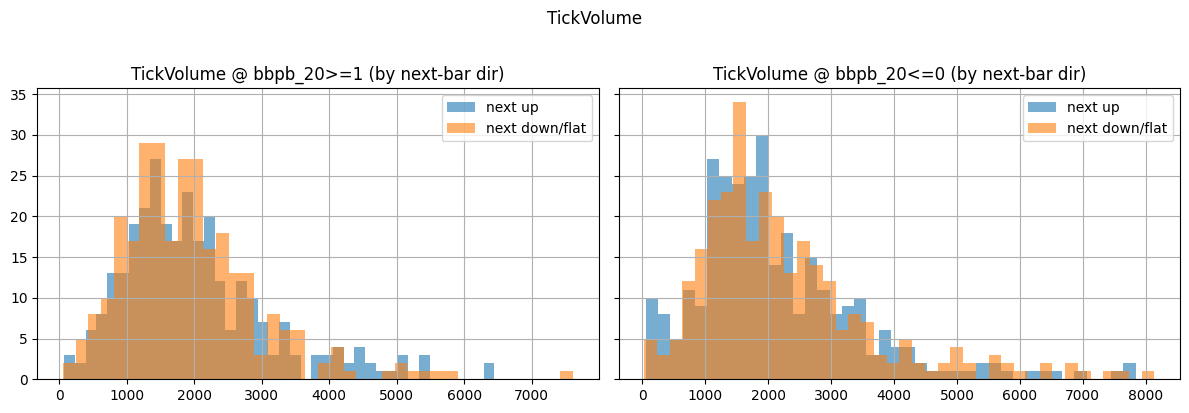

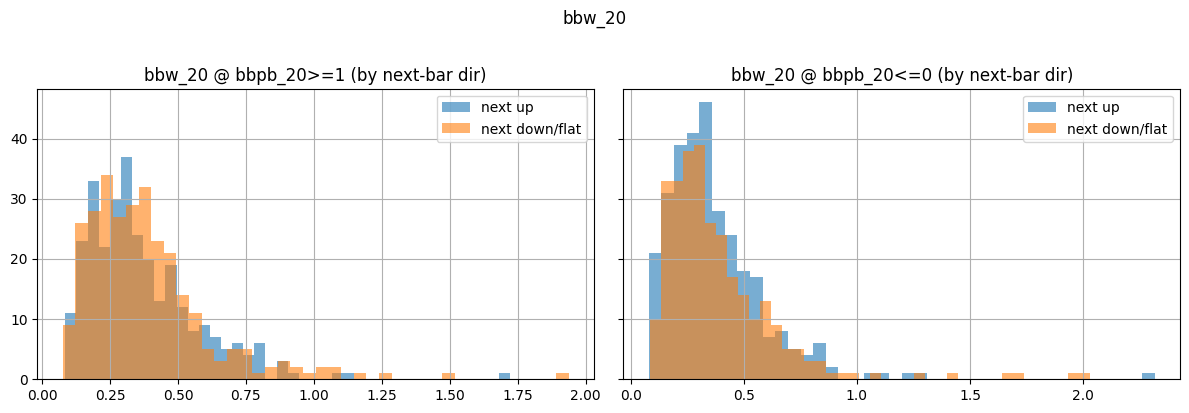

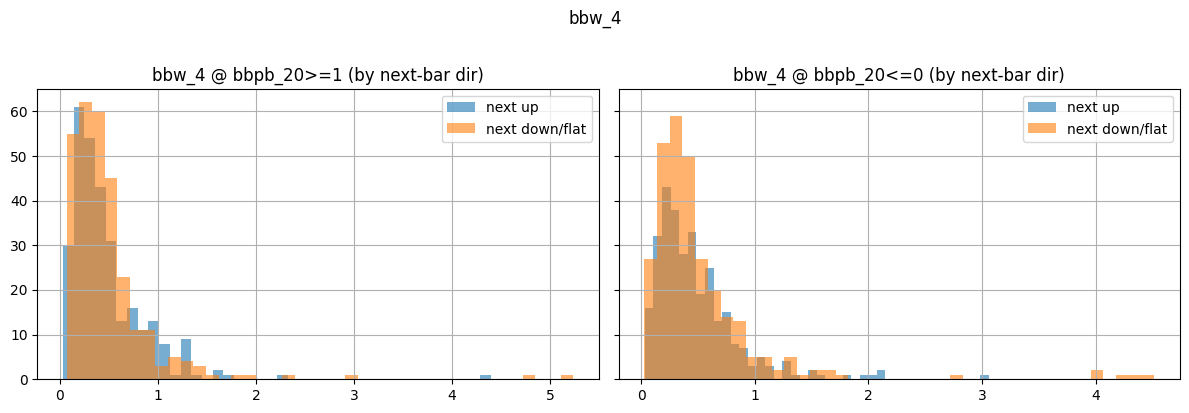

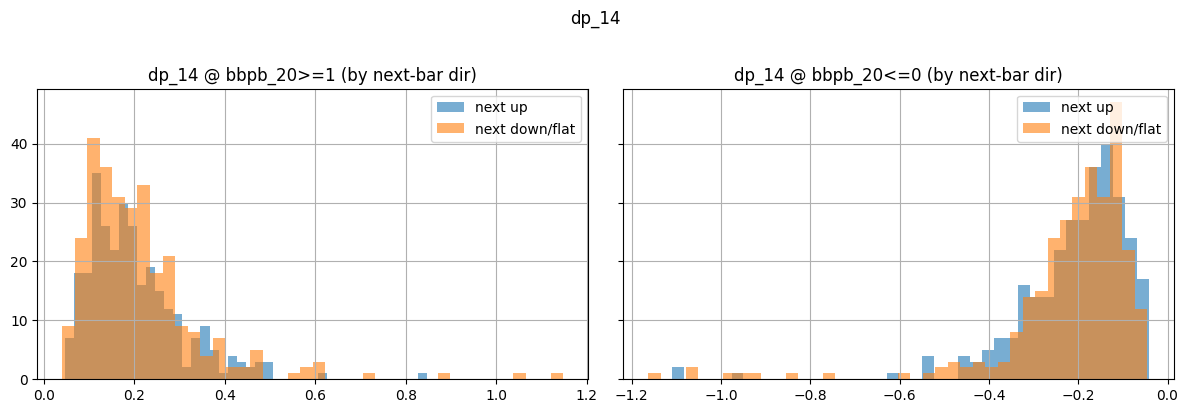

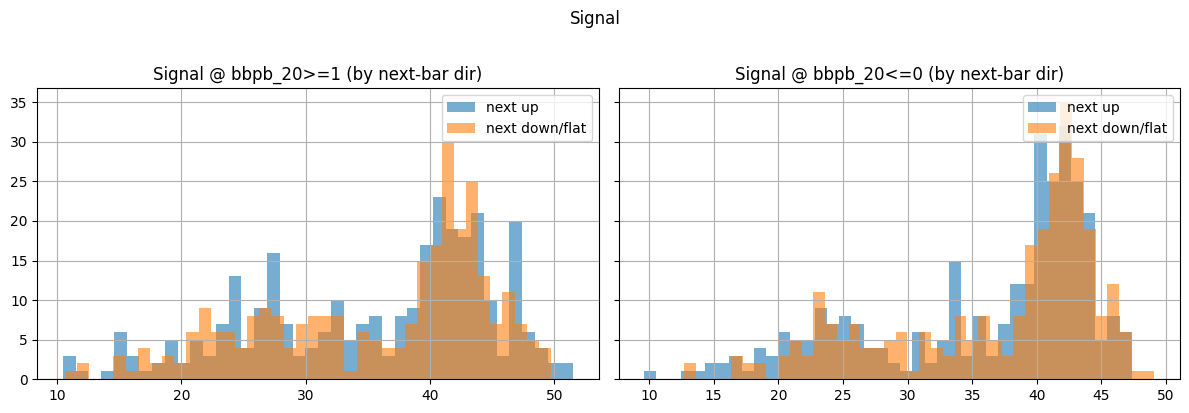

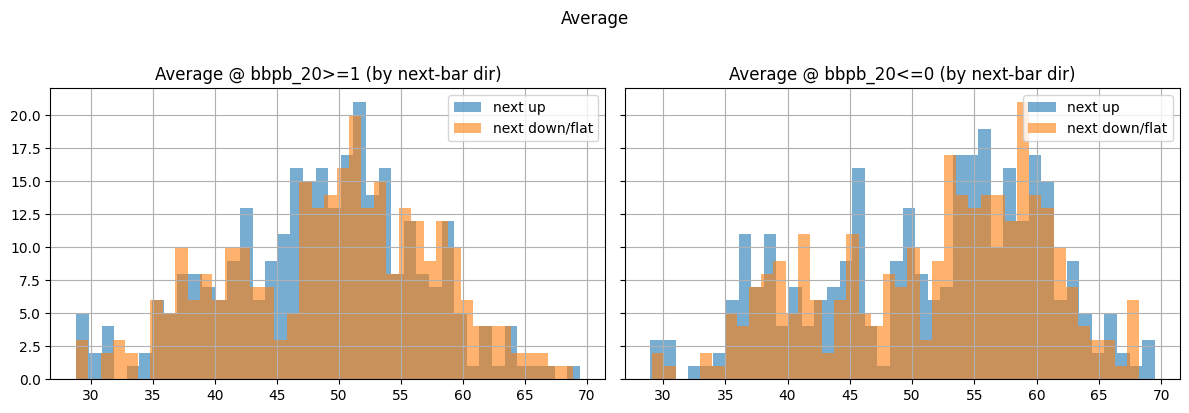

In [7]:
# ============================================
# 2. 피처별 히스토그램 (좌: bbpb_20>=1, 우: bbpb_20<=0)
# ============================================

# 보고 싶은 피처들
features = ["TickVolume", "bbw_20", "bbw_4", "dp_14", "Signal", "Average"]  # 원하는 대로 수정

for col in features:
    vals_up20_up   = df_up_20_up[col].dropna()
    vals_up20_down = df_up_20_down[col].dropna()
    vals_dn20_up   = df_dn_20_up[col].dropna()
    vals_dn20_down = df_dn_20_down[col].dropna()

    # 샘플 너무 적으면 스킵하고 싶으면 아래 주석 해제
    # if min(len(vals_up20_up), len(vals_up20_down),
    #        len(vals_dn20_up), len(vals_dn20_down)) < 10:
    #     continue

    fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

    # ========= (1) bbpb_20 >= 1 구간: up vs down =========
    ax = axes[0]
    ax.hist(
        vals_up20_up,
        bins=40,
        alpha=0.6,
        label="next up",
    )
    ax.hist(
        vals_up20_down,
        bins=40,
        alpha=0.6,
        label="next down/flat",
    )
    ax.set_title(f"{col} @ bbpb_20>=1 (by next-bar dir)")
    ax.legend(loc="upper right")
    ax.grid(True)

    # ========= (2) bbpb_20 <= 0 구간: up vs down =========
    ax = axes[1]
    ax.hist(
        vals_dn20_up,
        bins=40,
        alpha=0.6,
        label="next up",
    )
    ax.hist(
        vals_dn20_down,
        bins=40,
        alpha=0.6,
        label="next down/flat",
    )
    ax.set_title(f"{col} @ bbpb_20<=0 (by next-bar dir)")
    ax.legend(loc="upper right")
    ax.grid(True)

    plt.suptitle(col, y=1.02)
    plt.tight_layout()
    plt.show()


In [20]:
import numpy as np
import pandas as pd

# --------------------------------------------
# 상/하단 터치 서브셋
# --------------------------------------------
sub_up_all = df[cond_up_20].copy()   # bbpb_20 >= 1
sub_dn_all = df[cond_dn_20].copy()   # bbpb_20 <= 0

# 피처 + bin 간격 설정
features = ["TickVolume", "bbw_20", "bbw_4", "dp_14", "Signal", "Average"]

bin_steps = {
    "TickVolume": 1000,   # 1000 간격
    "bbw_20": 0.2,        # 0.2 간격
    "bbw_4": 0.5,         # 0.5 간격
    "dp_14": 0.1,         # 0.1 간격
    "Signal": 10,         # 10 간격
    "Average": 10,        # 10 간격
}

for col in features:
    step = bin_steps[col]

    # -------- 상단 구간 (bbpb_20>=1, suffix _1) --------
    sub_up = sub_up_all.dropna(subset=[col, "dir_h1"]).copy()
    if sub_up.empty:
        print(f"\n=== {col}: bbpb_20>=1 유효 데이터 없음 ===")
        continue

    min_v_up = sub_up[col].min()
    max_v_up = sub_up[col].max()

    start_up = np.floor(min_v_up / step) * step
    end_up   = np.ceil(max_v_up / step) * step

    bins_up = np.arange(start_up, end_up + step, step)
    if len(bins_up) < 2:
        print(f"\n=== {col}: bbpb_20>=1 bin 1개 이하 ===")
        continue

    sub_up[f"{col}_bin"] = pd.cut(
        sub_up[col],
        bins=bins_up,
        include_lowest=True,
    )

    total_up = len(sub_up)
    group_up = sub_up.groupby(f"{col}_bin")["dir_h1"]

    summary_up = pd.DataFrame({
        "count": group_up.size(),
        "p_up": group_up.apply(lambda s: (s == "up").mean()),
    })
    summary_up["pct"] = summary_up["count"] / total_up * 100
    summary_up = summary_up.sort_index(ascending=False)
    summary_up["cum_pct"] = summary_up["pct"].cumsum()

    summary_up["p_up"] = summary_up["p_up"].round(3)
    summary_up["pct"] = summary_up["pct"].round(2)
    summary_up["cum_pct"] = summary_up["cum_pct"].round(2)
    summary_up = summary_up.add_suffix("_1")  # 상단용 suffix

    # -------- 하단 구간 (bbpb_20<=0, suffix _0) --------
    sub_dn = sub_dn_all.dropna(subset=[col, "dir_h1"]).copy()
    if sub_dn.empty:
        print(f"\n=== {col}: bbpb_20<=0 유효 데이터 없음 ===")
        # 상단만 출력하고 계속
        combined = summary_up.copy()
        combined.index.name = f"{col}_bin"
        print(f"\n=== {col}: bbpb_20>=1 only ===")
        print(combined)
        continue

    min_v_dn = sub_dn[col].min()
    max_v_dn = sub_dn[col].max()

    start_dn = np.floor(min_v_dn / step) * step
    end_dn   = np.ceil(max_v_dn / step) * step

    bins_dn = np.arange(start_dn, end_dn + step, step)
    if len(bins_dn) < 2:
        print(f"\n=== {col}: bbpb_20<=0 bin 1개 이하 ===")
        combined = summary_up.copy()
        combined.index.name = f"{col}_bin"
        print(f"\n=== {col}: bbpb_20>=1 only ===")
        print(combined)
        continue

    sub_dn[f"{col}_bin"] = pd.cut(
        sub_dn[col],
        bins=bins_dn,
        include_lowest=True,
    )

    total_dn = len(sub_dn)
    group_dn = sub_dn.groupby(f"{col}_bin")["dir_h1"]

    summary_dn = pd.DataFrame({
        "count": group_dn.size(),
        "p_up": group_dn.apply(lambda s: (s == "up").mean()),
    })
    summary_dn["pct"] = summary_dn["count"] / total_dn * 100
    summary_dn = summary_dn.sort_index(ascending=False)
    summary_dn["cum_pct"] = summary_dn["pct"].cumsum()

    summary_dn["p_up"] = summary_dn["p_up"].round(3)
    summary_dn["pct"] = summary_dn["pct"].round(2)
    summary_dn["cum_pct"] = summary_dn["cum_pct"].round(2)
    summary_dn = summary_dn.add_suffix("_0")  # 하단용 suffix

    # -------- 상단/하단 통합 출력 --------
    combined = summary_up.merge(
        summary_dn,
        left_index=True,
        right_index=True,
        how="outer",
    )
    combined = combined.sort_index(ascending=False)
    combined.index.name = f"{col}_bin"

    print(f"\n=== {col}: bbpb_20>=1(_1) vs bbpb_20<=0(_0), step={step} ===")
    print(combined)



=== TickVolume: bbpb_20>=1(_1) vs bbpb_20<=0(_0), step=1000 ===
                  count_1  p_up_1  pct_1  cum_pct_1  count_0  p_up_0  pct_0  cum_pct_0
TickVolume_bin                                                                        
(8000.0, 9000.0]      NaN     NaN    NaN        NaN        1   0.000   0.17       0.17
(7000.0, 8000.0]      1.0   0.000   0.17       0.17        5   0.600   0.84       1.01
(6000.0, 7000.0]      2.0   1.000   0.34       0.51        9   0.444   1.52       2.53
(5000.0, 6000.0]     12.0   0.500   2.05       2.56       17   0.412   2.86       5.39
(4000.0, 5000.0]     21.0   0.714   3.59       6.15       24   0.458   4.04       9.43
(3000.0, 4000.0]     43.0   0.465   7.35      13.50       65   0.554  10.94      20.37
(2000.0, 3000.0]    166.0   0.482  28.38      41.88      143   0.469  24.07      44.44
(1000.0, 2000.0]    253.0   0.518  43.25      85.13      250   0.532  42.09      86.53
(-0.001, 1000.0]     87.0   0.483  14.87     100.00       80   0.

/var/folders/2s/lrz206250vbftls28pmlc2wh0000gn/T/ipykernel_88791/1336854606.py:49: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group_up = sub_up.groupby(f"{col}_bin")["dir_h1"]
/var/folders/2s/lrz206250vbftls28pmlc2wh0000gn/T/ipykernel_88791/1336854606.py:97: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group_dn = sub_dn.groupby(f"{col}_bin")["dir_h1"]
/var/folders/2s/lrz206250vbftls28pmlc2wh0000gn/T/ipykernel_88791/1336854606.py:49: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observe